In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1  
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

Using TensorFlow backend.


In [2]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [3]:
def build_model(train_x,train_y,n_input,n_out):
	# define parameters
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))
	# define model

	model = Sequential()
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features),return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features),return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', input_shape=(n_timesteps, n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='linear'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model
 


In [4]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


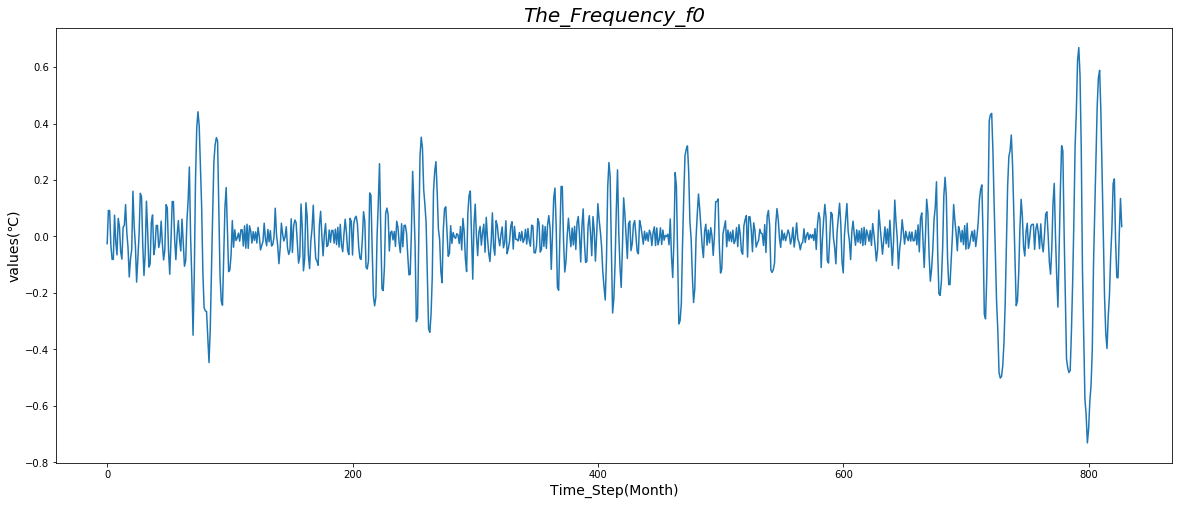

(1, 12, 1)
[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
(792, 12, 1)
(792, 12)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 11s - loss: 0.0201
Epoch 2/200
 - 4s - loss: 0.0194
Epoch 3/200
 - 2s - loss: 0.0182
Epoch 4/200
 - 2s - loss: 0.0177
Epoch 5/200
 - 3s - loss: 0.0171
Epoch 6/200
 - 3s - loss: 0.0169
Epoch 7/200
 - 3s - loss: 0.0169
Epoch 8/200
 - 4s - loss: 0.0165
Epoch 9/200
 - 3s - loss: 0.0166
Epoch 10/200
 - 7s - loss: 0.0182
Epoch 11/200
 - 3s - loss: 0.0166
Epoch 12/200
 - 4s - loss: 0.0168
Epoch 13/200
 - 3s - loss: 0.0166
Epoch 14/200
 - 4s - loss: 0.0169
Epoch 15/200
 - 4s - loss: 0.0163
Epoch 16/200
 - 4s - loss: 0.0157
Epoch 17/200
 - 4s - loss: 0.0162
Epoch 18/200
 - 3s - loss: 0

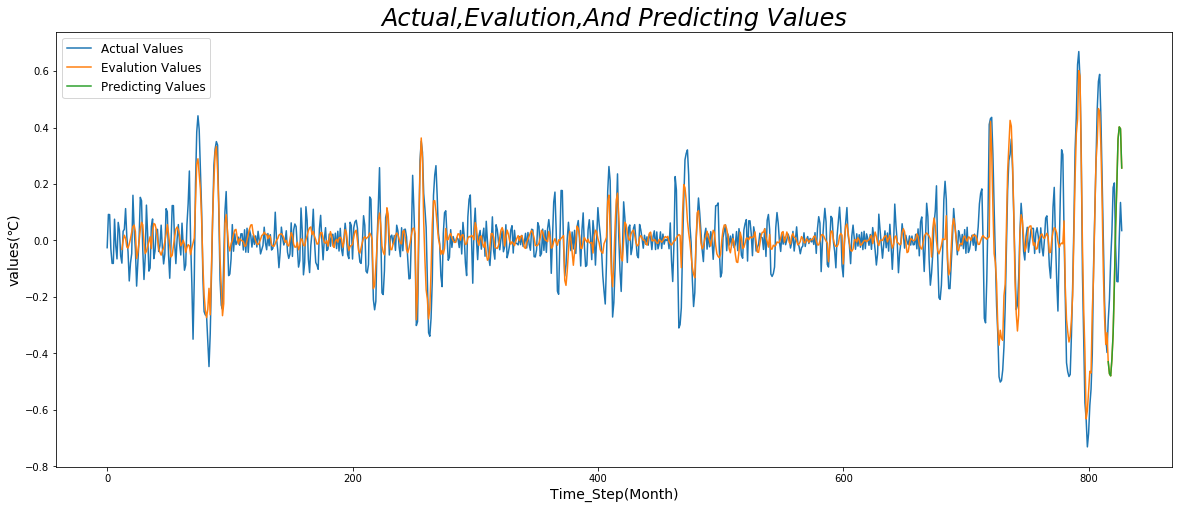

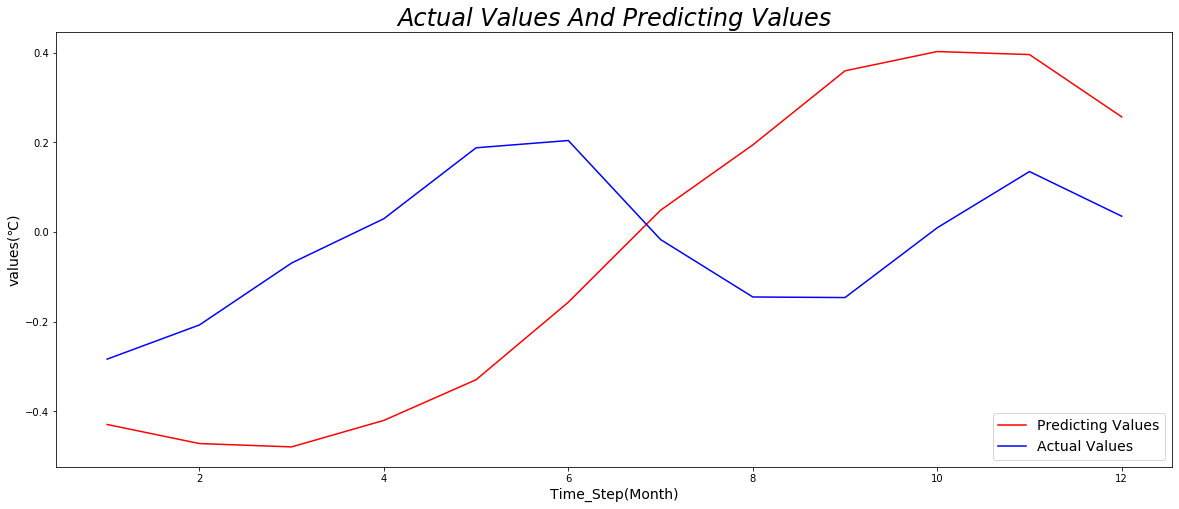

(828,)


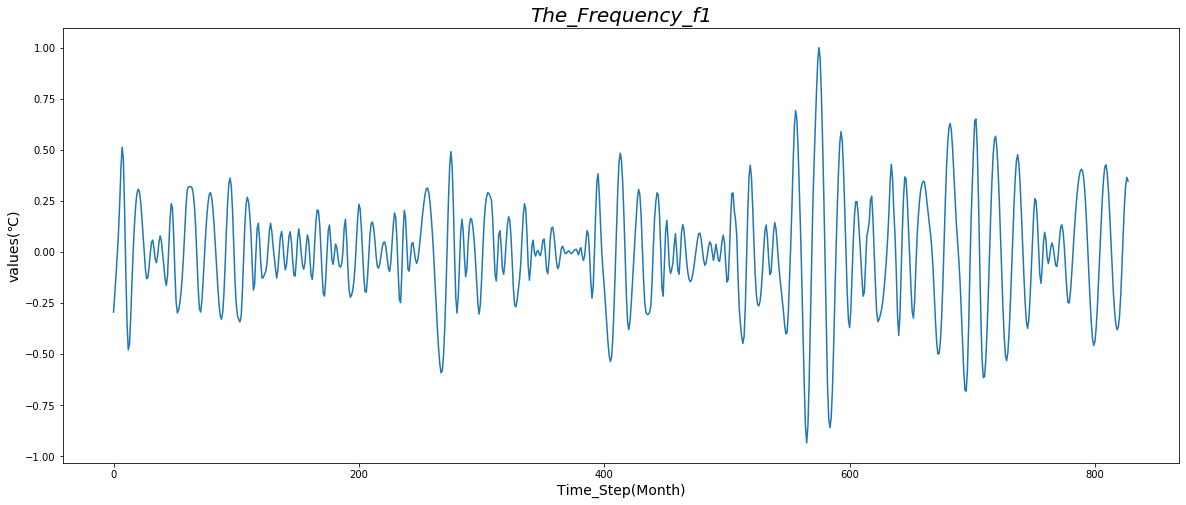

(1, 12, 1)
[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.0516
Epoch 2/200
 - 3s - loss: 0.0432
Epoch 3/200
 - 4s - loss: 0.0422
Epoch 4/200
 - 4s - loss: 0.0400
Epoch 5/200
 - 3s - loss: 0.0379
Epoch 6/200
 - 3s - loss: 0.0376
Epoch 7/200
 - 3s - loss: 0.0356
Epoch 8/200
 - 3s - loss: 0.0352
Epoch 9/200
 - 3s - loss: 0.0340
Epoch 10/200
 - 3s - loss: 0.0334
Epoch 11/200
 - 3s - loss: 0.0342
Epoch 12/200
 - 3s - loss: 0.0333
Epoch 13/200
 - 5s - loss: 0.0333
Epoch 14/200
 - 5s - loss: 0.0325
Epoch 15/200
 - 3s - loss: 0.0337
Epoch 16/200
 - 5s - loss: 0.0322
Epoch 17/200
 - 5s - loss: 0.0322
Epoch 18/200
 - 5s - loss: 0.0320
Epoch 19/200
 - 4s - loss: 0.0323
Epoch 20/200
 - 4s - loss: 0.0316
Epoch 21/200
 - 4s - loss: 0.0317
Epoch 22/200
 - 4s - loss: 0.0318
Epoch 23/200
 - 4s - loss: 0.0316
Epoch 24/200
 - 4s - loss: 0.0307
Epoch 25/200
 - 5s - loss: 0.0313
E

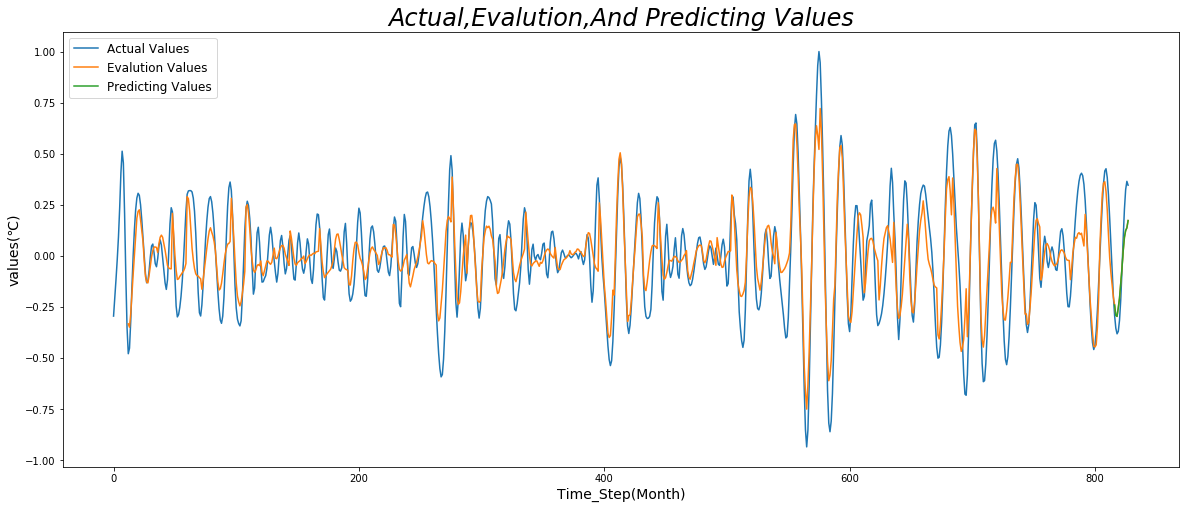

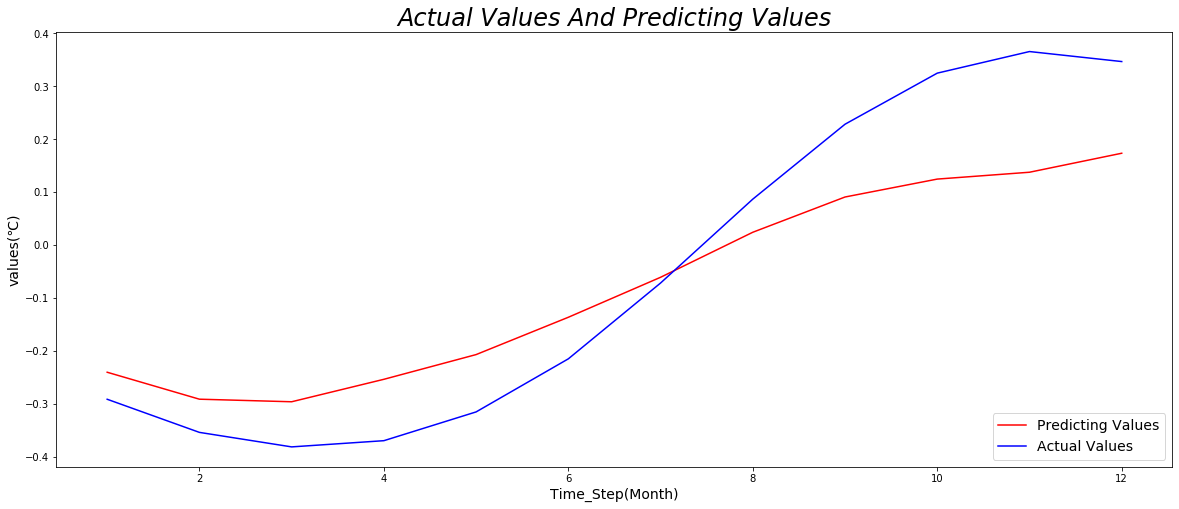

(828,)


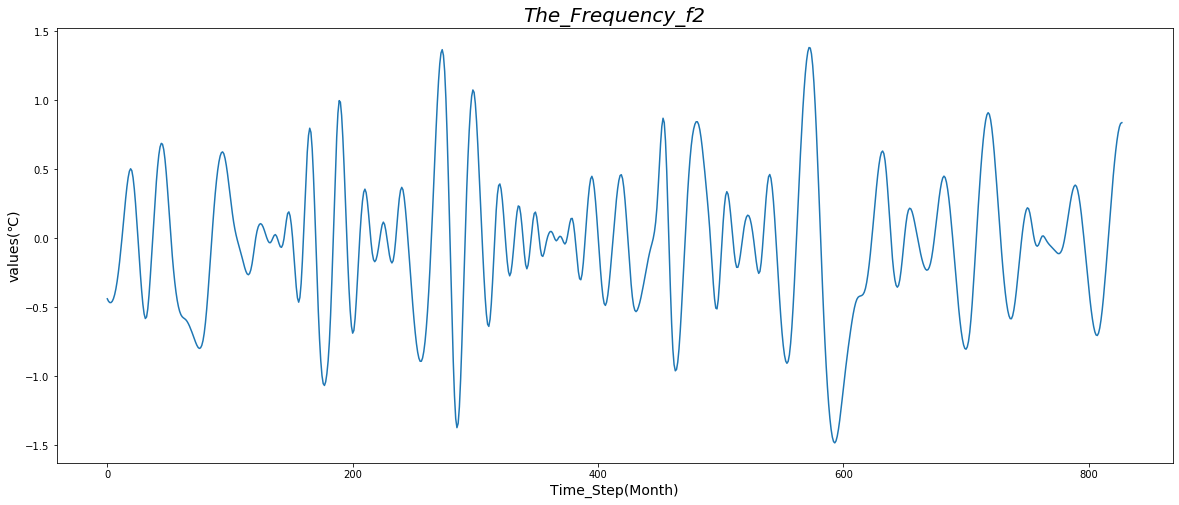

(1, 12, 1)
[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.2129
Epoch 2/200
 - 3s - loss: 0.1708
Epoch 3/200
 - 4s - loss: 0.1596
Epoch 4/200
 - 3s - loss: 0.1423
Epoch 5/200
 - 4s - loss: 0.1366
Epoch 6/200
 - 4s - loss: 0.1294
Epoch 7/200
 - 4s - loss: 0.1207
Epoch 8/200
 - 4s - loss: 0.1174
Epoch 9/200
 - 4s - loss: 0.1116
Epoch 10/200
 - 4s - loss: 0.1212
Epoch 11/200
 - 3s - loss: 0.1065
Epoch 12/200
 - 8s - loss: 0.1041
Epoch 13/200
 - 6s - loss: 0.1020
Epoch 14/200
 - 5s - loss: 0.0997
Epoch 15/200
 - 3s - loss: 0.0955
Epoch 16/200
 - 4s - loss: 0.1016
Epoch 17/200
 - 3s - loss: 0.1006
Epoch 18/200
 - 4s - loss: 0.1004
Epoch 19/200
 - 4s - loss: 0.0957
Epoch 20/200
 - 3s - loss: 0.0955
Epoch 21/200
 - 3s - loss: 0.0902
Epoch 22/200
 - 3s - loss: 0.0903
Epoch 23/200
 - 3s - loss: 0.0880
Epoch 24/200
 - 5s - loss: 0.0893
Epoch 25/200
 - 4s - loss: 0.0954
Epo

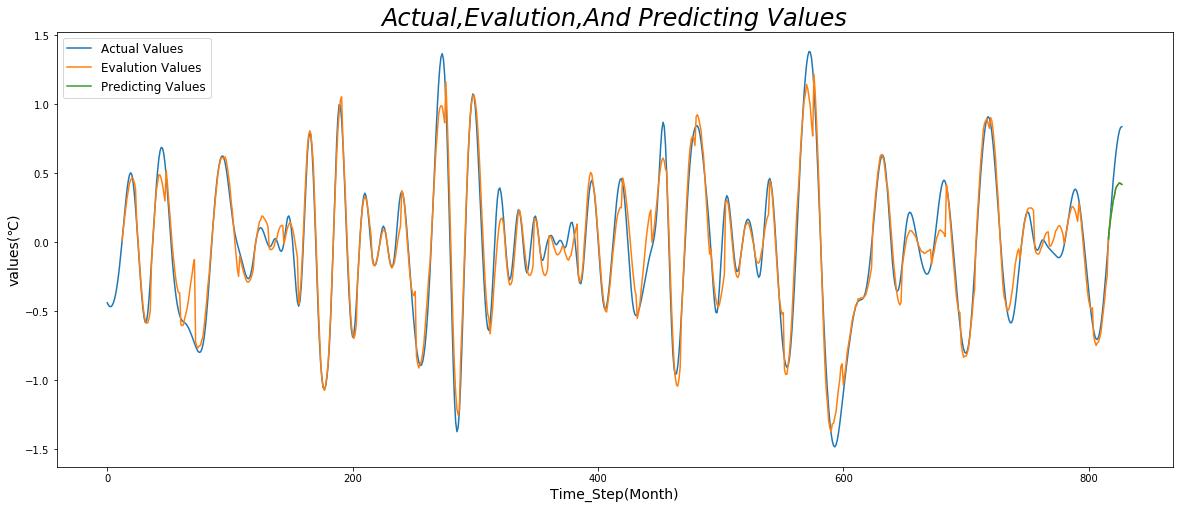

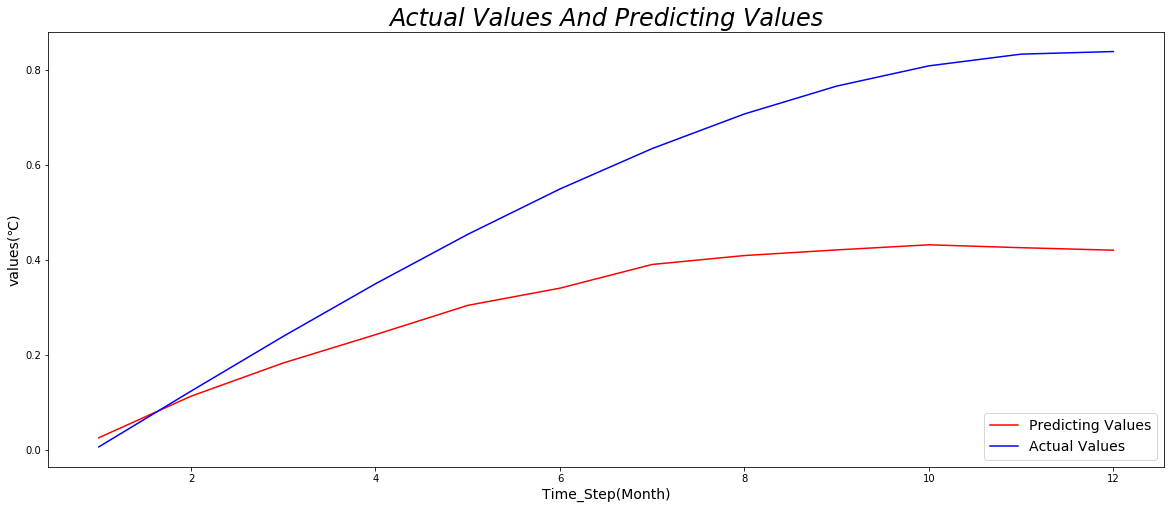

(828,)


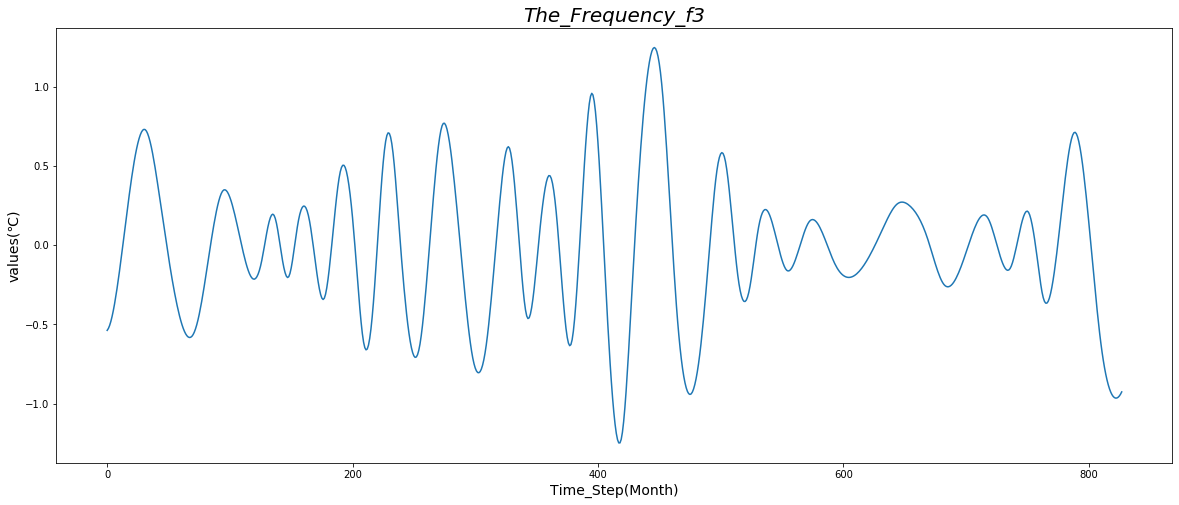

(1, 12, 1)
[-0.88131 -0.90671 -0.92735 -0.94342 -0.95507 -0.96249 -0.96584 -0.96529
 -0.96101 -0.95309 -0.94162 -0.92675]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 14s - loss: 0.1348
Epoch 2/200
 - 4s - loss: 0.0877
Epoch 3/200
 - 4s - loss: 0.0609
Epoch 4/200
 - 4s - loss: 0.0531
Epoch 5/200
 - 4s - loss: 0.0455
Epoch 6/200
 - 4s - loss: 0.0397
Epoch 7/200
 - 4s - loss: 0.0372
Epoch 8/200
 - 5s - loss: 0.0403
Epoch 9/200
 - 4s - loss: 0.0390
Epoch 10/200
 - 4s - loss: 0.0390
Epoch 11/200
 - 4s - loss: 0.0365
Epoch 12/200
 - 5s - loss: 0.0367
Epoch 13/200
 - 4s - loss: 0.0336
Epoch 14/200
 - 4s - loss: 0.0352
Epoch 15/200
 - 4s - loss: 0.0341
Epoch 16/200
 - 4s - loss: 0.0345
Epoch 17/200
 - 4s - loss: 0.0343
Epoch 18/200
 - 5s - loss: 0.0342
Epoch 19/200
 - 4s - loss: 0.0340
Epoch 20/200
 - 4s - loss: 0.0316
Epoch 21/200
 - 4s - loss: 0.0309
Epoch 22/200
 - 4s - loss: 0.0372
Epoch 23/200
 - 3s - loss: 0.0327
Epoch 24/200
 - 10s - loss: 0.0325
Epoch 25/200
 - 6s - loss: 0.0287
Epoch 26/200

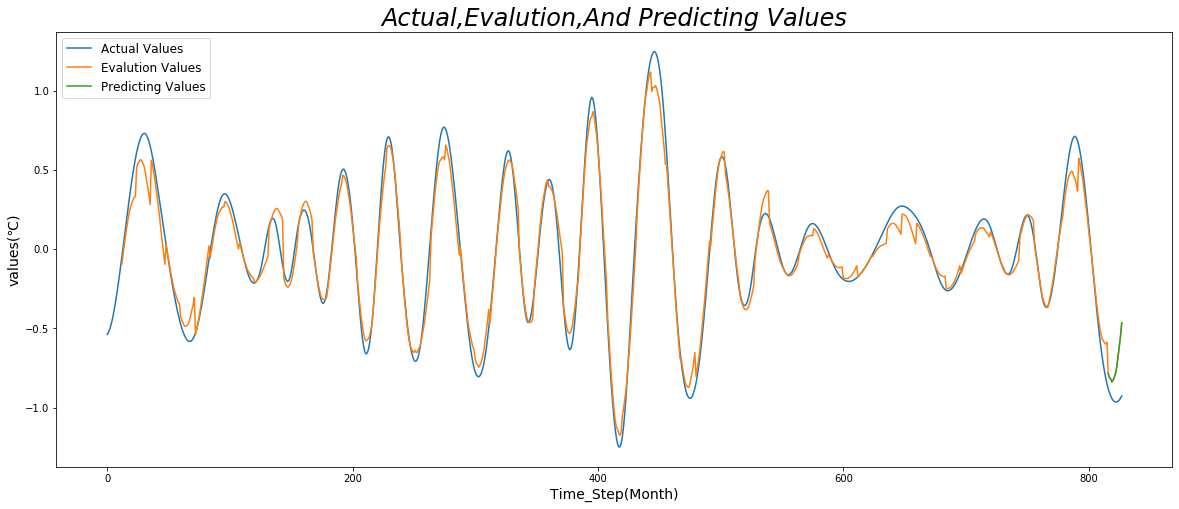

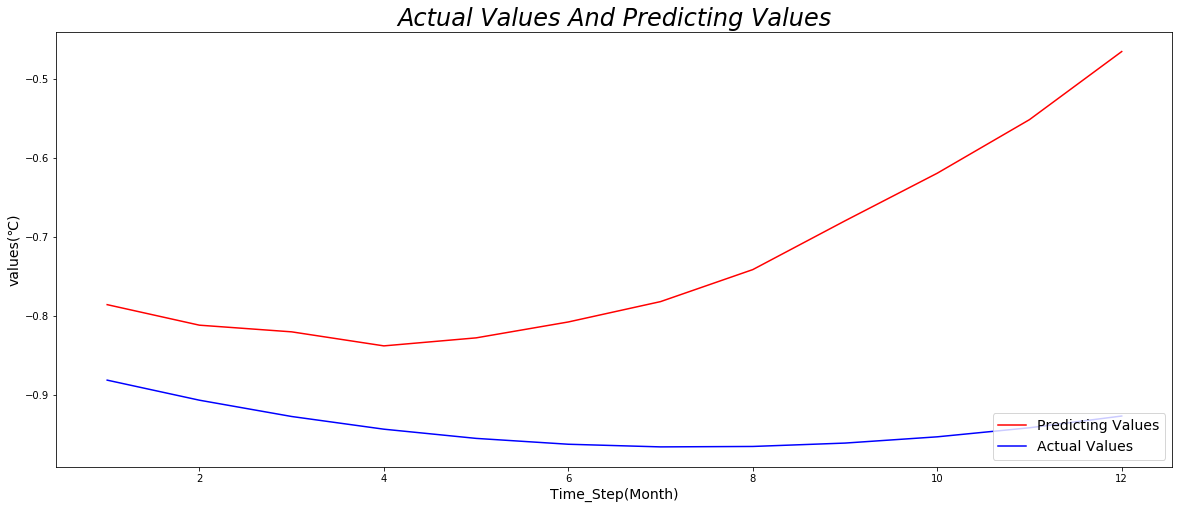

(828,)


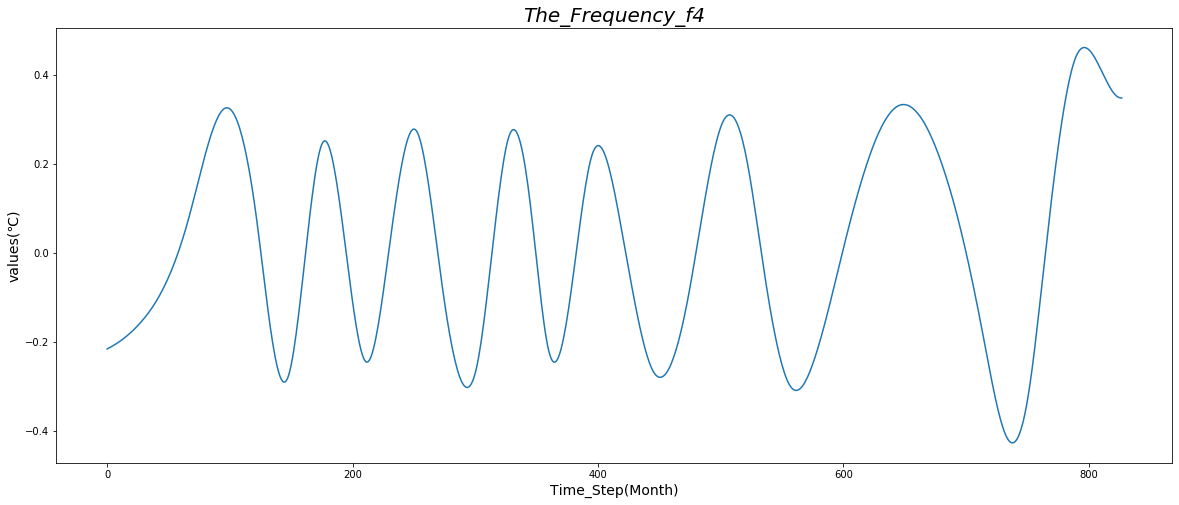

(1, 12, 1)
[0.37911 0.37411 0.36941 0.36506 0.36112 0.35764 0.35466 0.35226 0.35045
 0.34923 0.34856 0.34841]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 13s - loss: 0.0260
Epoch 2/200
 - 5s - loss: 0.0101
Epoch 3/200
 - 4s - loss: 0.0036
Epoch 4/200
 - 4s - loss: 0.0032
Epoch 5/200
 - 4s - loss: 0.0035
Epoch 6/200
 - 5s - loss: 0.0032
Epoch 7/200
 - 5s - loss: 0.0030
Epoch 8/200
 - 4s - loss: 0.0039
Epoch 9/200
 - 4s - loss: 0.0030
Epoch 10/200
 - 5s - loss: 0.0025
Epoch 11/200
 - 4s - loss: 0.0026
Epoch 12/200
 - 4s - loss: 0.0026
Epoch 13/200
 - 5s - loss: 0.0025
Epoch 14/200
 - 4s - loss: 0.0026
Epoch 15/200
 - 4s - loss: 0.0028
Epoch 16/200
 - 4s - loss: 0.0027
Epoch 17/200
 - 5s - loss: 0.0024
Epoch 18/200
 - 3s - loss: 0.0025
Epoch 19/200
 - 4s - loss: 0.0027
Epoch 20/200
 - 3s - loss: 0.0025
Epoch 21/200
 - 8s - loss: 0.0023
Epoch 22/200
 - 7s - loss: 0.0023
Epoch 23/200
 - 7s - loss: 0.0025
Epoch 24/200
 - 4s - loss: 0.0022
Epoch 25/200
 - 4s - loss: 0.0024
Epoch 26/200
 - 4s - loss

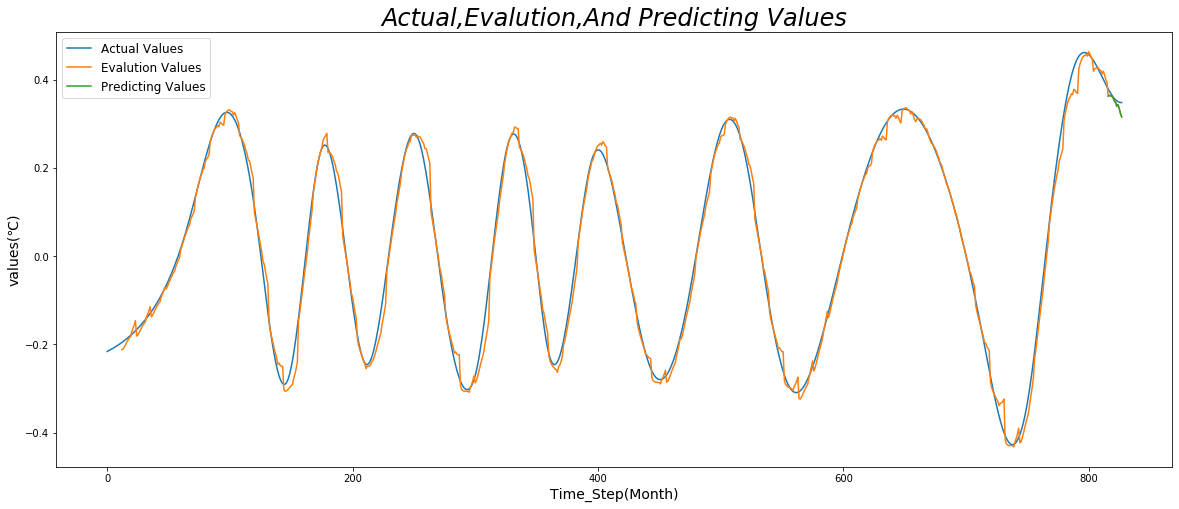

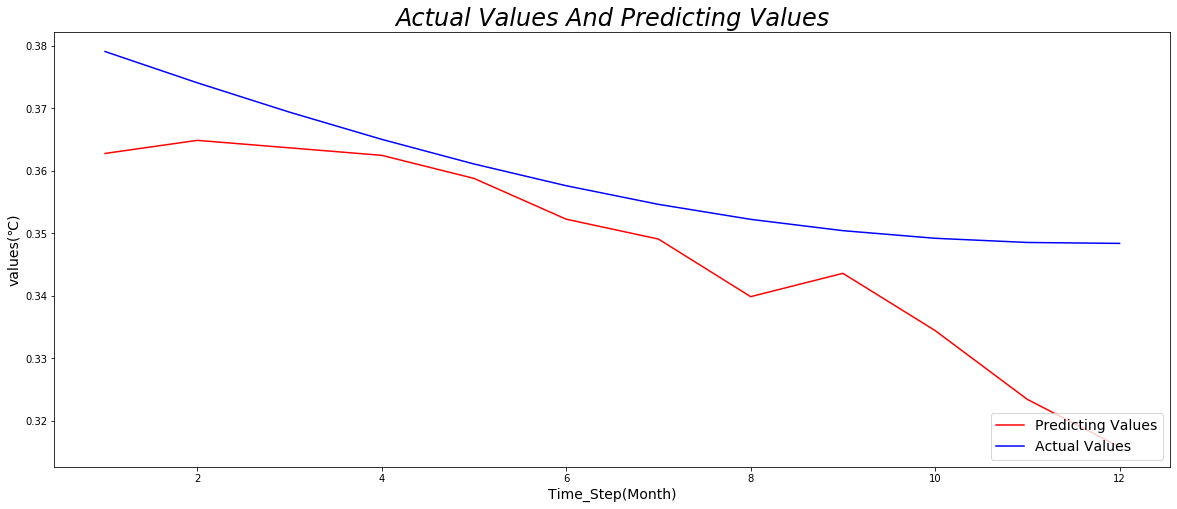

(828,)


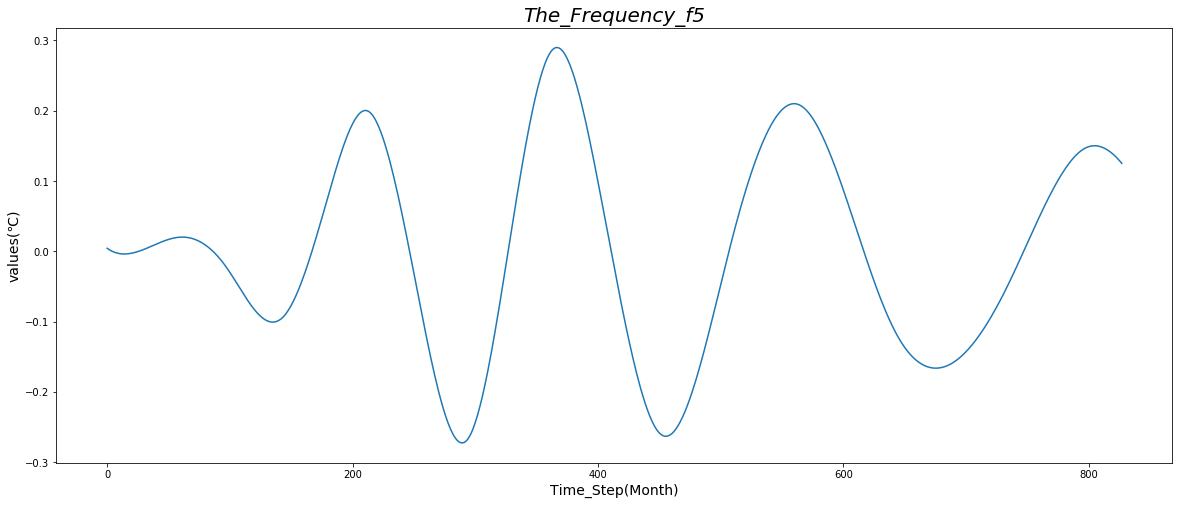

(1, 12, 1)
[0.1436  0.14239 0.14109 0.13969 0.1382  0.13661 0.13494 0.13318 0.13133
 0.1294  0.12738 0.12528]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 10s - loss: 0.0079
Epoch 2/200
 - 2s - loss: 0.0042
Epoch 3/200
 - 3s - loss: 0.0032
Epoch 4/200
 - 3s - loss: 0.0021
Epoch 5/200
 - 3s - loss: 0.0016
Epoch 6/200
 - 3s - loss: 9.0356e-04
Epoch 7/200
 - 5s - loss: 7.5934e-04
Epoch 8/200
 - 6s - loss: 6.7159e-04
Epoch 9/200
 - 6s - loss: 5.8962e-04
Epoch 10/200
 - 6s - loss: 6.0593e-04
Epoch 11/200
 - 3s - loss: 5.7794e-04
Epoch 12/200
 - 3s - loss: 7.1564e-04
Epoch 13/200
 - 4s - loss: 5.1809e-04
Epoch 14/200
 - 3s - loss: 4.5177e-04
Epoch 15/200
 - 5s - loss: 5.3010e-04
Epoch 16/200
 - 5s - loss: 4.8095e-04
Epoch 17/200
 - 5s - loss: 5.7993e-04
Epoch 18/200
 - 5s - loss: 6.8483e-04
Epoch 19/200
 - 7s - loss: 6.5212e-04
Epoch 20/200
 - 7s - loss: 5.1638e-04
Epoch 21/200
 - 6s - loss: 4.7035e-04
Epoch 22/200
 - 4s - loss: 5.0709e-04
Epoch 23/200
 - 4s - loss: 4.6084e-04
Epoch 24/200
 - 5s - 

[0.1391335  0.1395604  0.13780218 0.13559361 0.13356347 0.13224052
 0.13170852 0.13072293 0.12740956 0.12413172 0.12276847 0.11815339]


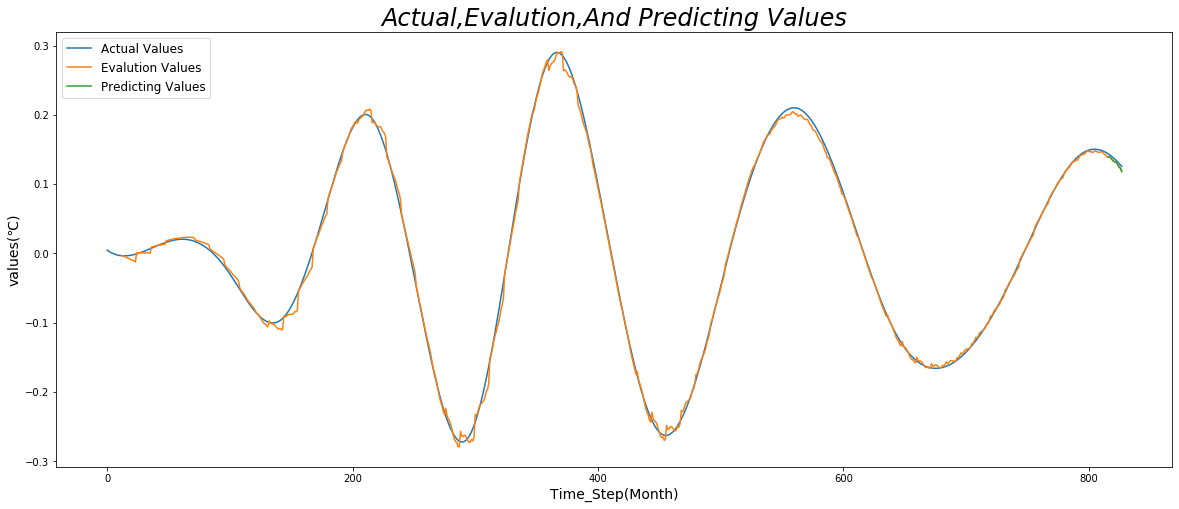

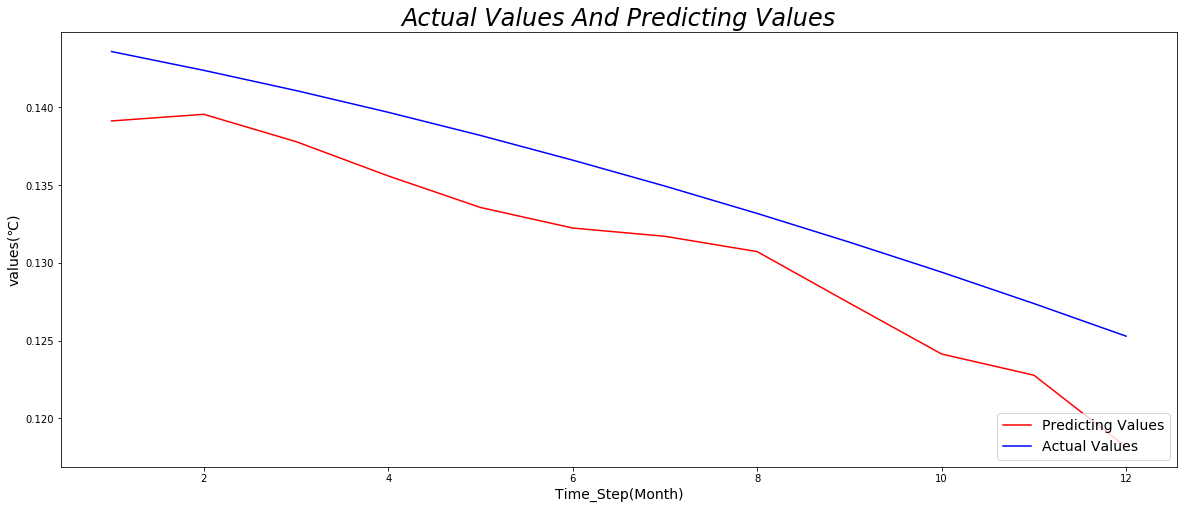

(828,)


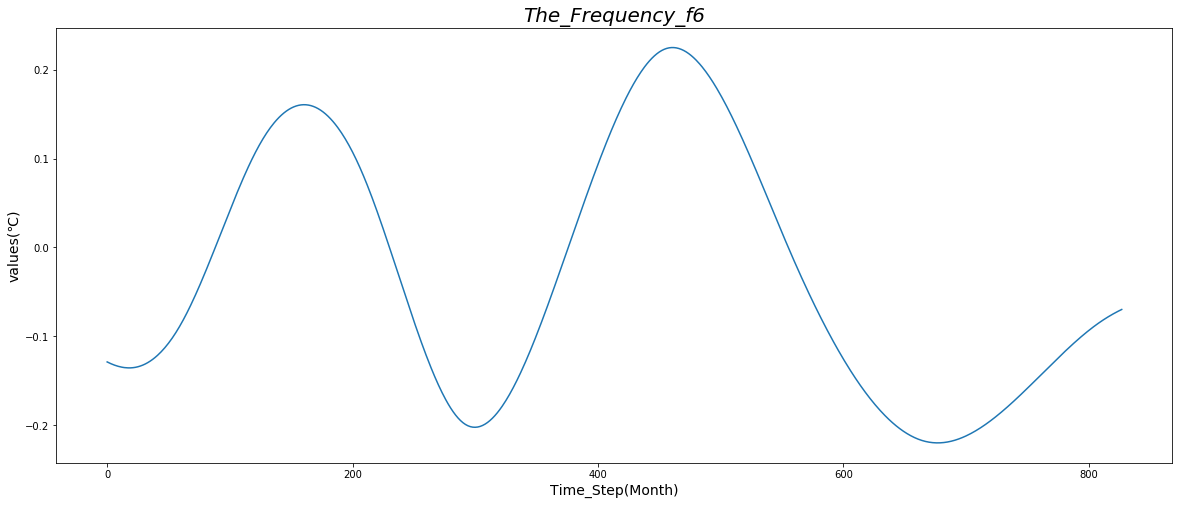

(1, 12, 1)
[-0.078087 -0.077258 -0.076445 -0.075649 -0.074869 -0.074105 -0.073357
 -0.072625 -0.071909 -0.071208 -0.070523 -0.069853]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 16s - loss: 0.0056
Epoch 2/200
 - 6s - loss: 0.0020
Epoch 3/200
 - 4s - loss: 0.0016
Epoch 4/200
 - 3s - loss: 0.0014
Epoch 5/200
 - 3s - loss: 0.0014
Epoch 6/200
 - 6s - loss: 0.0014
Epoch 7/200
 - 4s - loss: 0.0011
Epoch 8/200
 - 5s - loss: 9.9065e-04
Epoch 9/200
 - 4s - loss: 0.0011
Epoch 10/200
 - 5s - loss: 9.3314e-04
Epoch 11/200
 - 4s - loss: 8.2973e-04
Epoch 12/200
 - 3s - loss: 7.8959e-04
Epoch 13/200
 - 3s - loss: 7.6170e-04
Epoch 14/200
 - 3s - loss: 6.6766e-04
Epoch 15/200
 - 4s - loss: 6.8328e-04
Epoch 16/200
 - 3s - loss: 5.9064e-04
Epoch 17/200
 - 3s - loss: 5.5232e-04
Epoch 18/200
 - 5s - loss: 5.6216e-04
Epoch 19/200
 - 4s - loss: 5.7051e-04
Epoch 20/200
 - 3s - loss: 5.3653e-04
Epoch 21/200
 - 3s - loss: 5.3479e-04
Epoch 22/200
 - 3s - loss: 4.5059e-04
Epoch 23/200
 - 3s - loss: 3.6012e-04
Epoch 24/

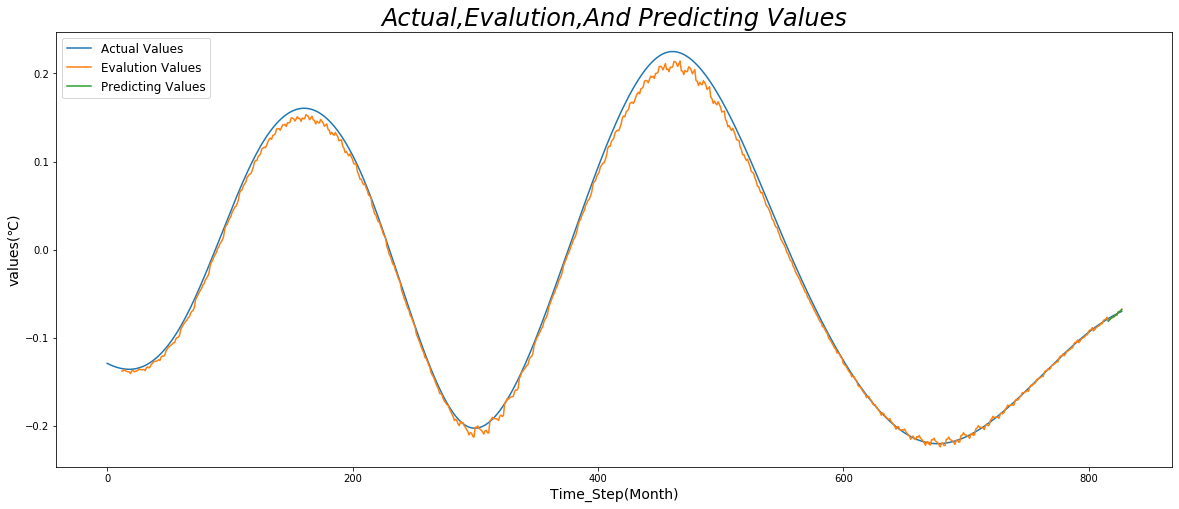

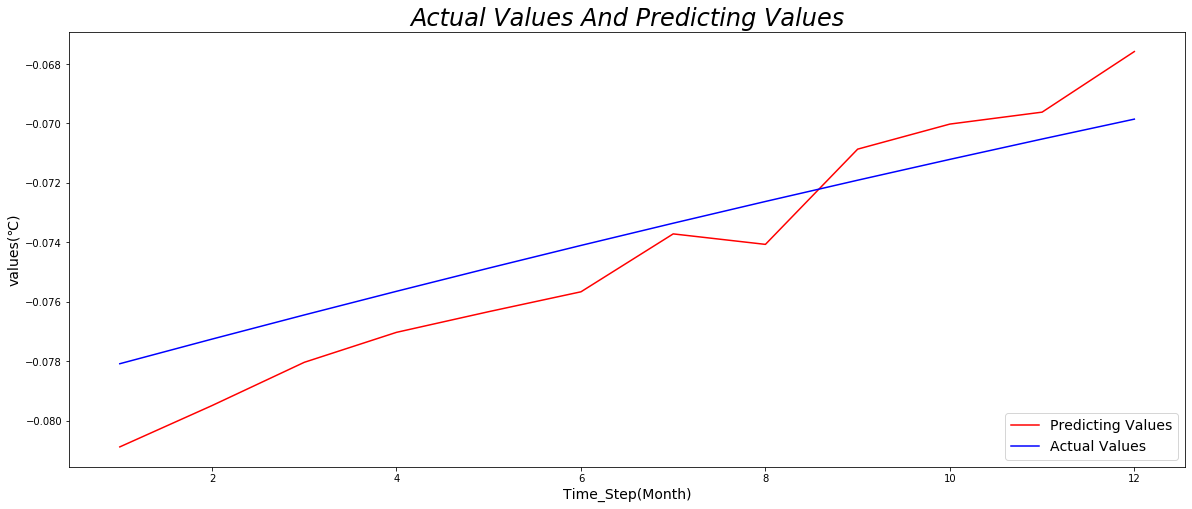

(828,)


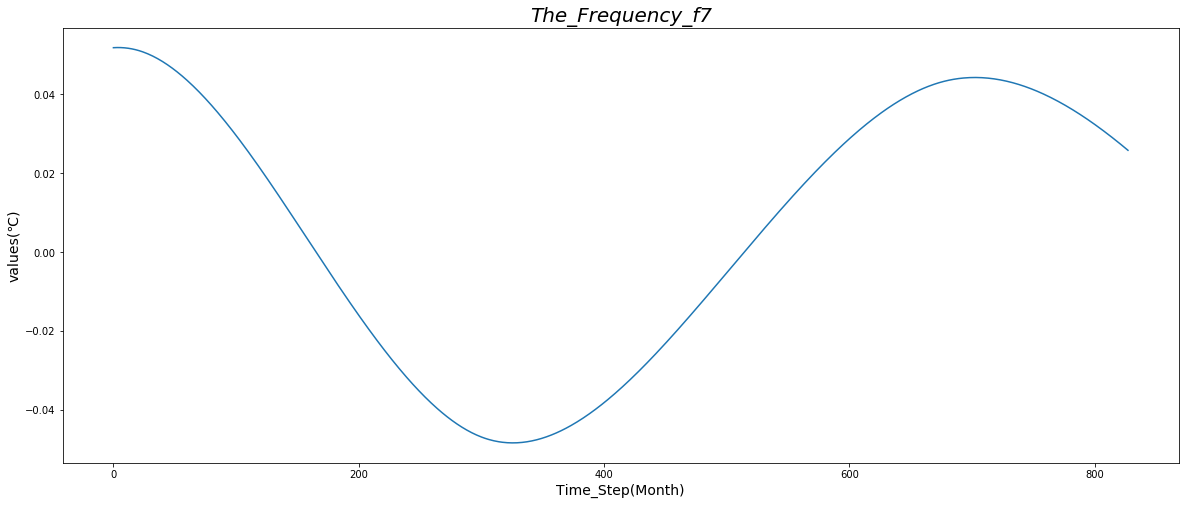

(1, 12, 1)
[0.02861  0.028363 0.028114 0.027865 0.027614 0.027362 0.027108 0.026853
 0.026597 0.026339 0.026081 0.025821]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 13s - loss: 5.8212e-04
Epoch 2/200
 - 3s - loss: 9.8700e-05
Epoch 3/200
 - 3s - loss: 5.0736e-05
Epoch 4/200
 - 3s - loss: 4.8644e-05
Epoch 5/200
 - 3s - loss: 4.1828e-05
Epoch 6/200
 - 3s - loss: 3.8172e-05
Epoch 7/200
 - 3s - loss: 3.9247e-05
Epoch 8/200
 - 3s - loss: 4.2525e-05
Epoch 9/200
 - 3s - loss: 4.2609e-05
Epoch 10/200
 - 3s - loss: 3.6582e-05
Epoch 11/200
 - 4s - loss: 3.9256e-05
Epoch 12/200
 - 3s - loss: 3.6626e-05
Epoch 13/200
 - 3s - loss: 4.7841e-05
Epoch 14/200
 - 3s - loss: 4.3661e-05
Epoch 15/200
 - 3s - loss: 4.0548e-05
Epoch 16/200
 - 3s - loss: 4.9707e-05
Epoch 17/200
 - 3s - loss: 3.4190e-05
Epoch 18/200
 - 3s - loss: 3.2823e-05
Epoch 19/200
 - 3s - loss: 2.8669e-05
Epoch 20/200
 - 5s - loss: 3.0294e-05
Epoch 21/200
 - 5s - loss: 3.4394e-05
Epoch 22/200
 - 3s - loss: 3.3330e-05
Epoch 23/200
 - 3s - loss: 

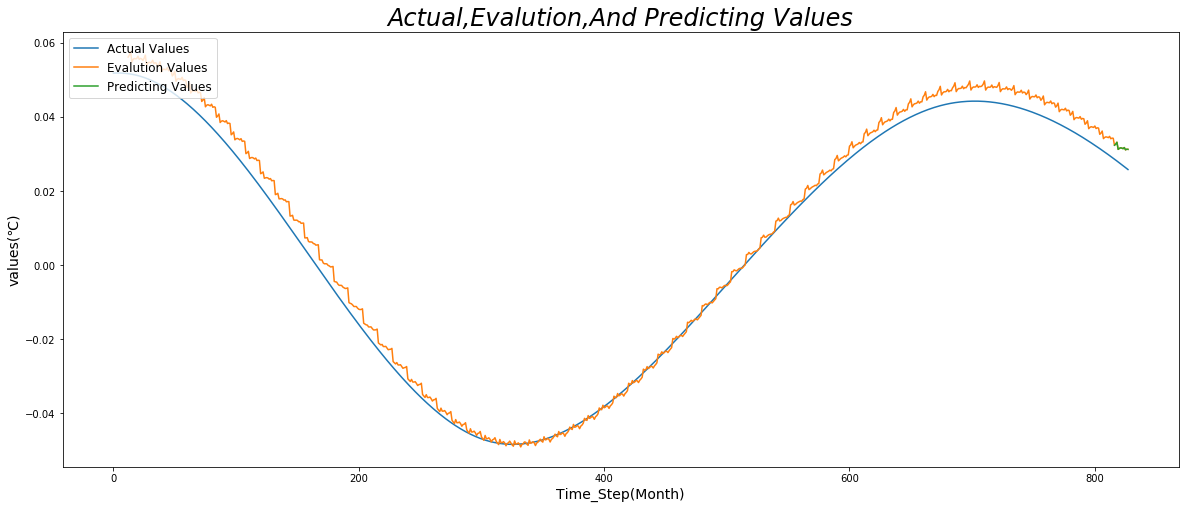

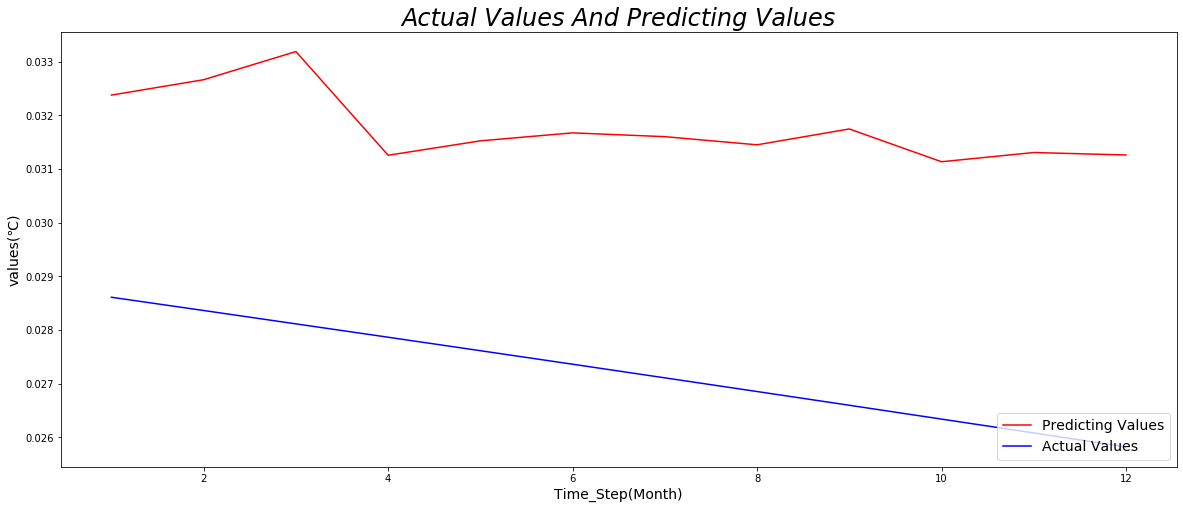

(828,)


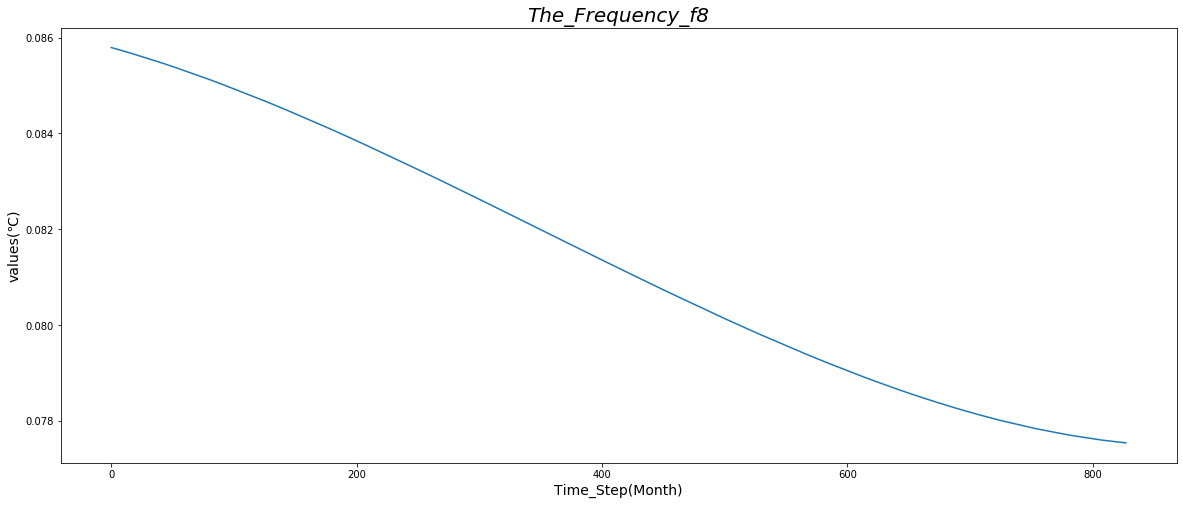

(1, 12, 1)
[0.077574 0.077571 0.077568 0.077565 0.077562 0.077559 0.077556 0.077554
 0.077551 0.077548 0.077546 0.077543]
(792, 12, 1)
(792, 12)
Epoch 1/200
 - 13s - loss: 8.0140e-04
Epoch 2/200
 - 3s - loss: 6.8701e-05
Epoch 3/200
 - 4s - loss: 3.3058e-05
Epoch 4/200
 - 3s - loss: 2.3396e-05
Epoch 5/200
 - 3s - loss: 1.8590e-05
Epoch 6/200
 - 3s - loss: 1.5008e-05
Epoch 7/200
 - 3s - loss: 1.2149e-05
Epoch 8/200
 - 3s - loss: 1.0493e-05
Epoch 9/200
 - 3s - loss: 9.5870e-06
Epoch 10/200
 - 3s - loss: 8.8880e-06
Epoch 11/200
 - 3s - loss: 8.4553e-06
Epoch 12/200
 - 3s - loss: 7.8265e-06
Epoch 13/200
 - 3s - loss: 7.2549e-06
Epoch 14/200
 - 3s - loss: 6.6424e-06
Epoch 15/200
 - 3s - loss: 5.6756e-06
Epoch 16/200
 - 3s - loss: 4.8961e-06
Epoch 17/200
 - 3s - loss: 5.0681e-06
Epoch 18/200
 - 3s - loss: 5.1558e-06
Epoch 19/200
 - 3s - loss: 5.2822e-06
Epoch 20/200
 - 3s - loss: 4.3714e-06
Epoch 21/200
 - 3s - loss: 2.7308e-06
Epoch 22/200
 - 3s - loss: 2.6620e-06
Epoch 23/200
 - 3s - loss: 

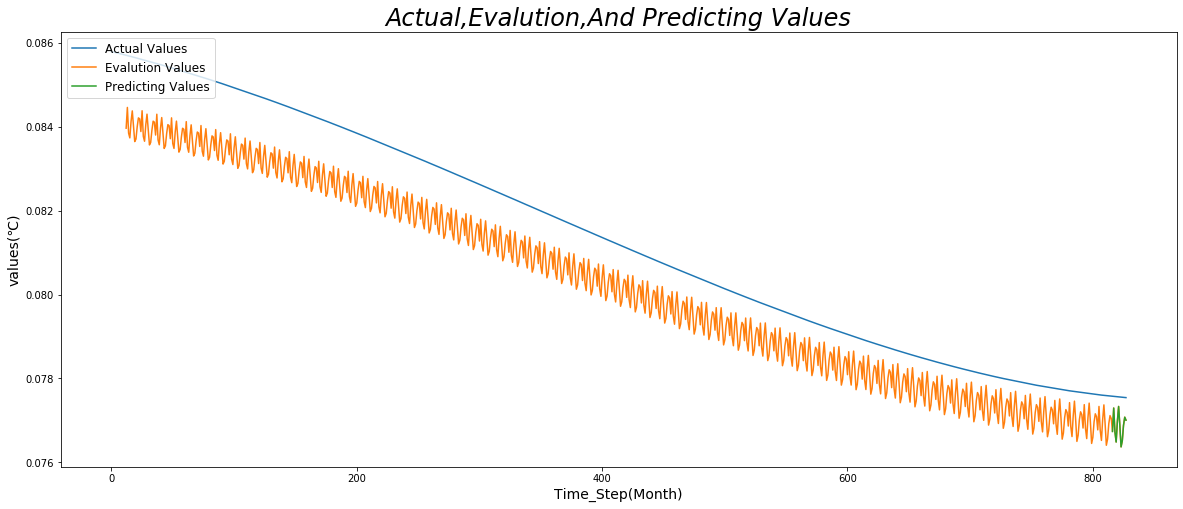

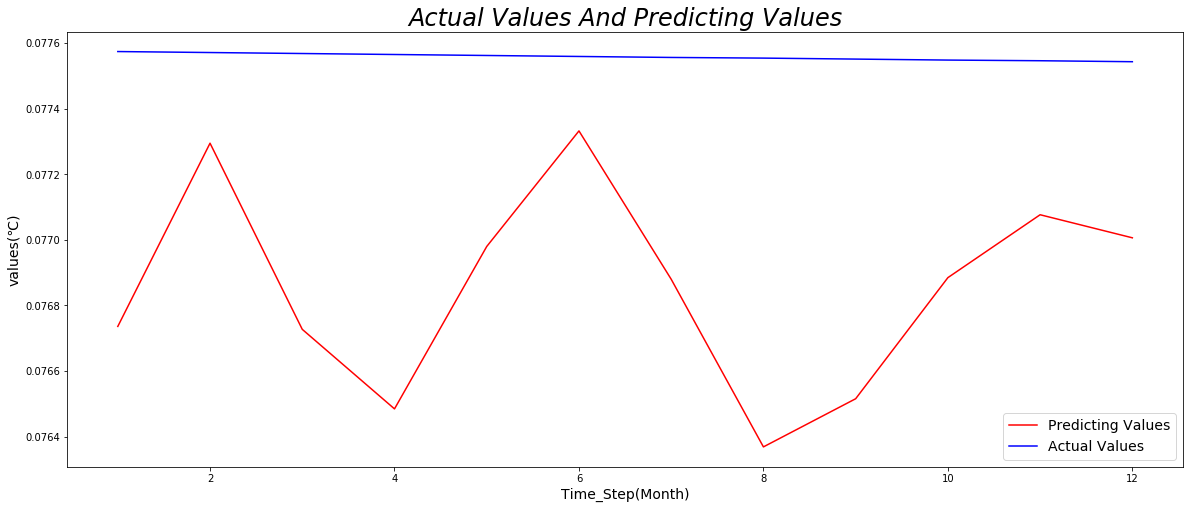

In [5]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]

signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_SoloLstm_EMD_prediction')==False):
    os.makedirs('12_months_SoloLstm_EMD_prediction')
        
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_SoloLstm_EMD_prediction/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (test.shape)
    print (test[0].reshape(-1))
    
    n_input = 12
    n_out=12
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    print (train_y.shape)
    
    model=build_model(train_x,train_y,n_input,n_out)
    score, scores,predictions = evaluate_model(train, test, n_input)
    trainPredict = model.predict(train)
    print (predictions.reshape(-1))
    
    
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)

# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1)):len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [6]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[0.07673584 0.07729451 0.07672693 0.07648442 0.07697958 0.077332
 0.07687974 0.07636851 0.07651532 0.0768846  0.07707638 0.07700605]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.12738, 0.12528]), array([-0.078087, -

In [7]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
-----------------------------------
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
-----------------------------------
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70

In [8]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i]))
    predicted_values = np.add(predicted_values, prediction_in_one[i])
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.42951873 -0.47207227 -0.47950822 -0.42040873 -0.3296513  -0.1567986
  0.04834764  0.19405662  0.35929275  0.40231532  0.3955881   0.2566244 ]
[-0.42951873 -0.47207227 -0.47950822 -0.42040873 -0.3296513  -0.1567986
  0.04834764  0.19405662  0.35929275  0.40231532  0.3955881   0.2566244 ]
the 1 frequence:
predicted_value:[-0.24039546 -0.291311   -0.2961642  -0.25374126 -0.20704247 -0.13655439
 -0.06103624  0.02401919  0.09060995  0.12445538  0.13739419  0.17328183]
[-0.66991419 -0.76338327 -0.77567244 -0.67414999 -0.53669377 -0.29335299
 -0.01268859  0.2180758   0.44990269  0.5267707   0.53298229  0.42990623]
the 2 frequence:
predicted_value:[0.02489985 0.11241145 0.18234438 0.24194123 0.30360478 0.3398467
 0.3897516  0.4085191  0.4204012  0.43116155 0.42507073 0.41980505]
[-0.64501434 -0.65097181 -0.59332806 -0.43220876 -0.23308899  0.04649371
  0.37706302  0.62659489  0.87030388  0.95793226  0.95805302  0.849711

[[-0.9]
 [-0.8]
 [-0.6]
 [-0.4]
 [-0.1]
 [ 0.1]
 [ 0.1]
 [ 0.2]
 [ 0.4]
 [ 0.7]
 [ 0.9]
 [ 0.8]]
[-0.90056228 -0.92775922 -0.88010037 -0.74132941 -0.53632648 -0.2432765
  0.11078626  0.38963144  0.69917231  0.83526605  0.89160451  0.85919529]


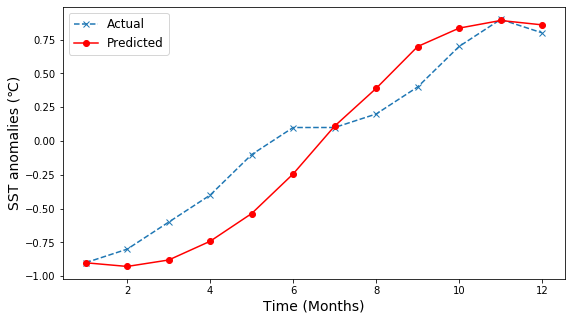

In [9]:
print (round_true_values)
print (predicted_values)

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 
 